<a href="https://colab.research.google.com/github/Ibrahimashraf135/Clinic-Project/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Install Required Libraries
!pip install transformers datasets torch scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 835.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#Import Libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler, EarlyStoppingCallback
from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm

<ipython-input-4-d685aa4ed7d7>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['labels'], palette='viridis')


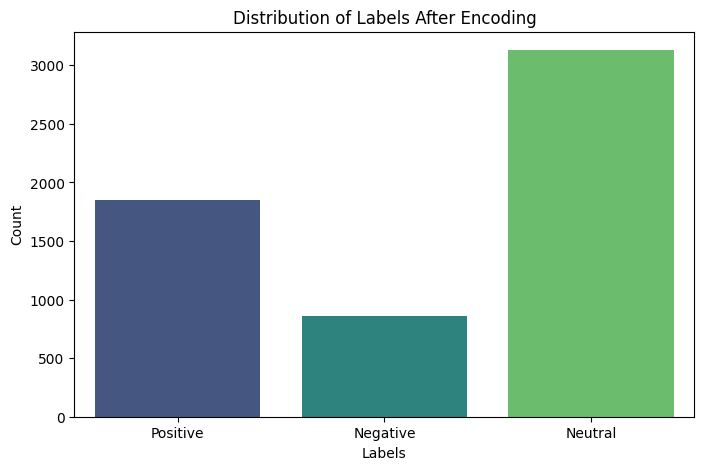

In [4]:
#Load and Preprocess the Dataset
# Load your dataset (replace with your dataset path)
df = pd.read_csv('data.csv')  # Ensure your dataset has columns: 'Sentence' and 'Sentiment'

# Data Cleaning
def clean_text(text):
    # Remove URLs, special characters, and convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

df['Sentence'] = df['Sentence'].apply(clean_text)

# Encoding Labels
label_to_id = {'positive': 0, 'negative': 1, 'neutral': 2}
df['labels'] = df['Sentiment'].map(label_to_id)

# Show the distribution of labels after encoding
plt.figure(figsize=(8, 5))
sns.countplot(x=df['labels'], palette='viridis')
plt.title('Distribution of Labels After Encoding')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Positive', 'Negative', 'Neutral'])
plt.show()

# Splitting the Data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)


In [5]:
#Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['Sentence'], padding="max_length", truncation=True)

# Tokenize the datasets
train_encodings = tokenizer(train_df['Sentence'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['Sentence'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['Sentence'].tolist(), truncation=True, padding=True)

# Convert to PyTorch datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_df['labels'].tolist())
val_dataset = SentimentDataset(val_encodings, val_df['labels'].tolist())
test_dataset = SentimentDataset(test_encodings, test_df['labels'].tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
#Load the BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
#Set Up Training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 10  # Set a higher number of epochs since early stopping will handle stopping
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Early Stopping Setup
early_stopping_patience = 2  # Stop if validation loss doesn't improve for 2 epochs
best_val_loss = float('inf')
patience_counter = 0


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/263 [00:00<?, ?it/s]

Epoch 1 completed. Train Loss: 0.6422, Val Loss: 0.4704


  0%|          | 0/263 [00:00<?, ?it/s]

Epoch 2 completed. Train Loss: 0.3488, Val Loss: 0.4178


  0%|          | 0/263 [00:00<?, ?it/s]

Epoch 3 completed. Train Loss: 0.2236, Val Loss: 0.4440


  0%|          | 0/263 [00:00<?, ?it/s]

Epoch 4 completed. Train Loss: 0.1906, Val Loss: 0.6389
Early stopping triggered at epoch 4!


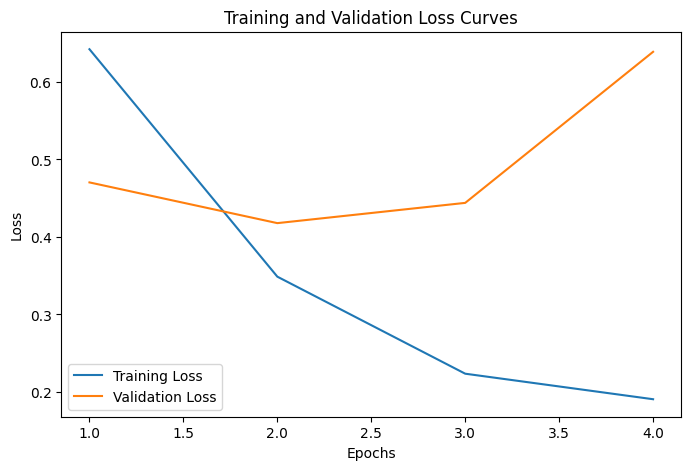

In [8]:
# Step 7: Train the Model with Early Stopping
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch in tqdm(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    epoch_val_loss = 0
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1} completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch + 1}!")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Plot training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 80.24%
Precision: 0.7899
Recall: 0.8024
F1-Score: 0.7912


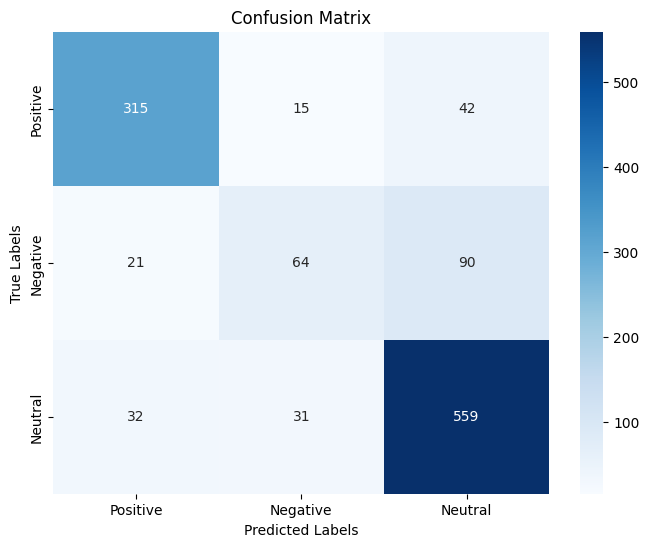

In [9]:
#Evaluate the Model
model.eval()
predictions, true_labels = [], []

for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(batch['labels'].cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [10]:
#Save the Model
model.save_pretrained('./fine-tuned-bert-sentiment')
tokenizer.save_pretrained('./fine-tuned-bert-sentiment')

('./fine-tuned-bert-sentiment/tokenizer_config.json',
 './fine-tuned-bert-sentiment/special_tokens_map.json',
 './fine-tuned-bert-sentiment/vocab.txt',
 './fine-tuned-bert-sentiment/added_tokens.json')

In [11]:
#Function to Make Predictions
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=-1).item()
    id_to_label = {0: 'positive', 1: 'negative', 2: 'neutral'}
    return id_to_label[pred]

# Test the function
test_sentences = [
    "The GeoSolutions technology will leverage Benefon 's GPS solutions...",
    "$ESI on lows, down $1.50 to $2.50 BK a real possibility",
    "According to the Finnish-Russian Chamber of Commerce, all the major construction companies of Finland are operating in Russia."
]

for sentence in test_sentences:
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {predict_sentiment(sentence)}\n")

Sentence: The GeoSolutions technology will leverage Benefon 's GPS solutions...
Predicted Sentiment: positive

Sentence: $ESI on lows, down $1.50 to $2.50 BK a real possibility
Predicted Sentiment: negative

Sentence: According to the Finnish-Russian Chamber of Commerce, all the major construction companies of Finland are operating in Russia.
Predicted Sentiment: neutral

